# Generate a Model to Classify Sentiment of a Review Text




Congratulations! You're a movie director, and you just released a film you poured your soul (and money) into making. You are curious as to what people thought of your movie. Reviews are pouring in every day, hundreds upon hundreds. You want to read through them all, but you physically can't.

On top of being a director, you are also a machine learning programmer, and you think it would be cool to make a model that can look at the text of any review and classify whether it is positive or negative, just by looking at the words. 

You find a giant dataset of IMDB reviews for a variety of movies, tagged for having `positive` (1) or `negative` (0) sentiments, depending on the rating. 

With this IMDB dataset, you decided to build and train an AI `Sentiment Analysis` model that can classify any review as positive or negative. That way, you can run the model on any review or comment that comes in for your movie and quickly tell if it is positive or negative without reading it yourself. 

(Note: This model is called a `Naive-Bayes Classifier`. This model can actually compute the sentiment for **any** text -- reviews, tweets, comments, etc!)

(Another note: This is a difficult task! Do not be discouraged if you struggle, and don't be scared to ask for help.)

## Import Libraries (Do not edit) 

Load python packages necessary for building the sentiment analysis model download the IMDB dataset. Do not edit this cell. 

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive # file
import string # tokenize
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt # confusion matrix
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split # model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# for testing later
! gdown --id 1IViQp6-J-uZYOsZY4nw_XLE3y9QXhyIw
import testing_aides as tester



### What does your data look like? (Do Not Edit)

In [ ]:
# get the data!
! gdown --id 1vexo0MMtjPzSv5CONn5t8QH3IKvewedk
reviewData = pd.read_csv("/content/labeledTrainData.tsv", delimiter="\t")
reviewData.head() # what does this file look like?

## Introduction

In lecture, you learned how to compute the sentiment of a text using `multinomial Naive-Bayes`. Recall you need two different kinds of probability - `prior` and `posterior`. 

So, there are three parts to writing this code:

1.   Calculating **prior probabilities** using the given reviews (the "train data") **(Part 1)**
2.   Creating methods to calculate **posterior probabilities** of individual words in a review **(Part 2)**
3.   Classifying each review in the "test data" as positive or negative based on the combined prior and posterior probabilities **(Part 3)**

The goal is to write code that classifies each review in a **list of reviews** (`reviews_test`) as negative (0) or positive (1) based on probabilities. The final result should be a **list of sentiments** (`classified_sentiments`), which has one sentiment value for each test review.
- Ex. [0, 1, 1, 0, 1...] 


### Variables to Know
These are provided variables that you will have to use to develop your code! Know them well.
*   `sentimentClasses` is a list of the sentiments, `0` (which represents negative) and `1` (which represents positive).
  * `sentimentClasses = [0,1]`
  * We will later *classify* each test review into the positive or negative class.
  
*   `reviews` is a list of all the **review texts**. 
  * This is the *review* column of your data table.
  * Ex. `["This was a great movie", "Wow! What a flop!", ...]`
*   `sentiment` is a list of the **sentiments** (0 or 1), corresponding to each review from `reviews`. This is the *sentiment* column of the data file.
  *  This is the *sentiment* column of your data table
  * Ex. `[1, 0, 0, 1, ...]`

`reviews[0]` corresponds to `sentiments[0]`, and so on.
* Ex. `"This was a great movie"` corresponds to `1` (positive)

**Note:** The cell below defines these variables for you. You do not need to define them yourself.


In [ ]:
# Provided variables (DO NOT EDIT!)

# reviews is the list of reviews
reviews = reviewData['review'].to_numpy()   # from 'review' column
print(reviews)
print(type(reviews))
print(len(reviews))
# sentiments is the list of corresponding sentiments
sentiments = reviewData['sentiment'].values   # from 'sentiment' column
print(sentiments)
# split reviews and sentiments for training and testing
reviews_train, reviews_test, sentiments_train, sentiments_test = train_test_split(reviews, sentiments, test_size=0.99, random_state=RANDOM_SEED)

# store the two unique sentiments, 0 (negative) and 1 (positive) in a sentimentClasses
sentimentClasses = np.unique(sentiments) # [0, 1]



---


## Part 1: Calculate Prior Probabilities



### Group Reviews by Sentiment Class
First, it's useful to group all the reviews in the training dataset by sentiment. 

Say you do this by creating one list of all the positive reviews, and one list of all the negative reviews. We can store these lists in a **dictionary**. 

We will use dictionaries in this lab to organize our data into our two sentiment classes, 0 and 1.

This is what the dictionary `ReviewsByClass` should look like:
- Keys: the sentiment classes, 0 and 1
- Values: lists of all the negative reviews, and all the positive reviews (respectively)

*Example*: Hypothetically, say your reviews list was: 
  > `["Good acting.", "I love this film!", "Truly horrible. What a flop."]`

...and your sentiments list was:
  > `[1, 1, 0]`

`ReviewsByClass` should look something like:
  > `{0: ["Truly horrible. What a flop."], 1: ["Good acting.", "I love this film!"]}`

  - Dictionaries have the format `{key: value, key: value, ...}`

In [ ]:
# TO DO: fill in ReviewsByClass
# ReviewsByClass should have two keys, 0 and 1 (one for each sentiment class).
# the value for 0 should be a list of all the negative reviews
# the value for 1 should be a list of all the positive reviews

# first step: go through all the reviews. for each review, sort them into either
# negative or positive list based on what its corresponding sentiment is.

ReviewsByClass = {} 

for c in sentimentClasses: # for each class
  ReviewList = [] # list of all reviews under class
  for i in range(len(reviews)): # go through all reviews
    if (sentiments[i] == c): # if classes match
      ReviewList.append(reviews[i]) # append that review to the list
  ReviewsByClass[c] = ReviewList # list is the value, class is key

### Calculate the Prior Probabilities
Complete a `dictionary` called `PriorProbabilityByClass`.
- Keys: the sentiment classes, 0 and 1
- Values: the prior probabilities
  - prior probability: the probability that **any** review is in a particular sentiment class

**Note:** **Prior probability of a class = log((# of items in that class) / (total # of items))**

*Example*: Hypothetically, say your reviews list was: 
  > `["Good acting.", "I love this film!", "Truly horrible. What a flop."]`

...and your sentiments list was:
  > `[1, 1, 0]`

There is 1 negative review, and 2 positive reviews. In total, there are 3 reviews. 

Therefore, the negative prior probability is `1/3`, and the positive prior  probability is `2/3`.

Your final dictionary, `PriorProbabilityByClass`, for this example dataset should look something like:
  > `{0: 0.33, 1: 0.67}`


In [5]:
# TO DO: fill in PriorProbabilityByClass
# PriorProbabilityByClass also has two keys, one for each sentiment class.
# the values for each key should be the prior probability for each corresponding class.
# ^ a decimal value -> log(# of items in that class / total # of items)

# Hint: can you use ReviewsByClass for this?

PriorProbabilityByClass = {}

totalRevCount = len(reviews) # total # of reviews
for c in sentimentClasses:
  classRevCount = len(ReviewsByClass[c]) # compute # of reviews in P & N 
  PriorProbabilityByClass[c] = math.log(classRevCount/totalRevCount) # probability is value, class is key
print(PriorProbabilityByClass)

{0: -0.6931471805599453, 1: -0.6931471805599453}


## Part 2: Create Methods to Calculate Posterior Probabilities




To write the classification code, you will need some **helper methods and variables** to help calculate the posterior probabilities. Build them by following the steps below. Each step depends on the last! 

*Note*: Additional information for each of the steps is above their code cells.
Testing cells are provided after each step so you can check your progress.

1. Write a method to `tokenize` a review
2. Create the dictionary `BagOfWordsByClass`, which holds a **Bag of Words** dictionary for each sentiment class
3. Write a method `computePosteriorProbs(word, c, reviewsByClass, bagOfWords)`

### Task 1: Tokenize (preprocessing)
Write a method to `tokenize` a review.*
  - You should do **preprocessing** on the review (this means getting rid of anything from the text that won't be useful for the analysis)
    - Make the text lowercase
    - Strip the text of any invalid characters (like `\`)
  - Finally, split the review into a list of individual words, and **return** that list.
    - You can do this by splitting by punctuation, spaces...

**Hint**: the Python **lower(), strip(), replace(), split()** methods

*Making this a method is useful later on, because you will need to tokenize a LOT of reviews.


*Example*: 

`result = tokenize("Yikes! That movie stunk a \lot\.")`

`result` should be something like `["yikes", "that", "movie", "stunk", "a", "lot"]`


In [6]:
# input: a review
# RETURN: a list of preprocessed words
def tokenize(review):
    # Preprocessing (any order):
    # - make the text lowercase
    # - strip the text of any unneccessary characters
    # - split the text into a list of words

    review = review.lower() # lowercase it
    review = review.split(" ") # split by spaces
    #print(review)
    finalRev = []
    for rev in review:
       rev = rev.strip() # strip of chars at beginning and end
       rev = rev.replace('\\', '') # get rid of weird chars
       rev = rev.replace('<', '')
       rev = rev.replace('>', '')
       rev = rev.replace('.', '') # ...
       finalRev.append(rev)

    return finalRev

In [7]:
# testing cell (optional): tokenize a review using your method!
# the output should be a list of plain words.
# suggestions to tokenize:
# - the first review in the data (reviews[0])
# - the tenth review in the data (reviews[9])
print(tokenize(reviews[0]))

print(tokenize(reviews[9]))


['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', "i've", 'started', 'listening', 'to', 'his', 'music,', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there,', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again', 'maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent', 'moonwalker', 'is', 'part', 'biography,', 'part', 'feature', 'film', 'which', 'i', 'remember', 'going', 'to', 'see', 'at', 'the', 'cinema', 'when', 'it', 'was', 'originally', 'released', 'some', 'of', 'it', 'has', 'subtle', 'messages', 'about', "mj's", 'feeling', 'towards', 'the', 'press', 'and', 'also', 'the', 'obvious', 'message', 'of', 'drugs', 'are', 'bad', "m'kaybr", '/br', '/visually', 'impressive', 'but', 'of', 'course', 'this', 'is', 'all', 'abou

### Task 2: Create and store bag of words for each class
Create the dictionary `BagOfWordsByClass`, which holds a **Bag of Words** dictionary **for each sentiment class**. 


Here, you will create **two** Bags of Words, one for 0 (negative class) and one for 1 (positive class) and store them both inside `BagOfWordsByClass`:
- Keys: the two sentiment classes
- Values: the two corresponding Bag of Words dictionaries



**Bag Of Words** is a dictionary with
- Keys: **unique** words in the text
- Values: the word **count**; how many of those words seen in the text.
  - Here, the "text" is a list of reviews


*Example*: Given the list `["happy birthday", "i am happy", "who am i"]`
- Bag of Words: `{"happy": 2, "birthday": 1, "i": 2, "am": 2, "who": 1}`



**Hint**: 
- For each class, go through the reviews, each review word by word (what method have we written to split reviews into words?). 
- For each word: if the word is already in your Bag Of Words dictionary for that class (as a key), increase the word count (the value of that key). 
- If the word is NOT in your dictionary already, you will have to **add it to the dictionary**.


How do you check if a word is in your Bag Of Words?

  - You can use the keyword `in` to check if a key exists in a dictionary:
      - ex. `if "funny" in someArbitraryBagOfWords:`

  - You can also use `set`s to store all the unique words you've seen so far in a class or overall. 
    - A `set` is basically a `list` of unique things that don't have an order. 
    - It's a lot quicker to check if something is in a `set` than if it is in a `list`. 

A `set` we have declared for you is called `vocab`, to keep track of all the unique words you see in the dataset, regardless of class. If you see a unique word, add to `vocab`.
* `vocab` --> set of **all unique words**
  * This is useful later on.


Finally, we provide a **testing aide** for this part, `testBagOfWordsByClass`, which you can use to check your final `BagOfWordsByClass` dictionary against the original dataset. 
- Don't worry if your dictionary isn't 100% accurate; your `tokenize()` method may just look different from the tester's. This is just a sanity check.

In [8]:
# create two bag of words dictionaries, one for neg class, one for pos class
# for each review in neg class, split it into words
# and for each word, if it is new to neg bag of words, add() to neg bag of words, 
# if not, add to the count in neg bag of words.
# same for pos.
# note: also fill vocab: add any new word to vocab
# finally, store both in BagOfWordsByClass, by class.

BagOfWordsByClass = {}
vocab = set()   # set of all unique words. add to it as you go along


for c in sentimentClasses: # for each class
  bagOfWords = {} # class-specific
  
  for review in ReviewsByClass[c]: # for each review in the class
    wordList = tokenize(review) # list of tokenized words from review
   
    for word in wordList: # for each word

      if word not in bagOfWords:
        bagOfWords[word] = 1  # initialize count
      else:
        bagOfWords[word] += 1 # add to count

      if word not in vocab: # setting up an overall vocab list for alter
        vocab.add(word)
  
  if c == 0:
    BagOfWordsByClass[0] = bagOfWords
  else:
    BagOfWordsByClass[1] = bagOfWords



In [9]:
# testing cell (optional): run this cell after completing BagOfWordsByClass.
# to see how accurate your bag-of-words dictionary is.
# this is working code - you don't have to write your own testing code here.
# change the testWord and run the cell again!

testWord = "horribly"
tester.testBagOfWordsByClass(testWord, reviews, sentiments, BagOfWordsByClass)

# !! don't worry if the numbers aren't exactly the same !!

# IMPORTANT: remember that your bag-of-words uses TOKENIZED words - words that
# have gone through whatever preprocessing you wrote in tokenize().
# as the words in the original dataset are unprocessed, this may result in inconsistencies.

# the code uses its OWN VERSION of tokenize() that lowercases and gets rid of symbols.
# so, there still may be inconsistencies in word counts.

--- in original dataset ---
40 occurrences of horribly in positive reviews
163 occurrences of horribly in negative reviews
--- in BagOfWordsByClass ---
41 occurrences of horribly in positive reviews
167 occurrences of horribly in negative reviews


### Task 3: Calculate posterior probabilities
3. Write a method `computePosteriorProbs(word, c, reviewsByClass, bagOfWords)`
  - This calculates **posterior probability**: the probability of a given **word** being in a given **class**.
    - Parameters include:
      - `word`, a string, e.g. "great"
      - `c`, a given class, e.g. 1
      - `reviewsByClass`, the dictionary `ReviewsByClass`
      - `bagOfWordsByClass`, the dictionary `BagOfWordsByClass`
  - `computePosteriorProbs` should return a number, the probability value.

**Note: Posterior Probabilty given word and class = log( `# of that word in the class` + 1 / `# of words in the class` + `# of unique words in total`)**


**Note 2:** Sometimes, a word will be in one class but not the other. (Ex. "fantastic" might have been seen in the positive class, but not the negative class). 
- So, you must check whether the inputted `word` is in the Bag of Words for the inputted `class`.
  - If it isn't, you will have to **add that word to the bag of words for that class with the initial count `0`**.

In [17]:
# helper vars for computePosteriorProbs
# calculating these inside the function takes too long 
negWordCounts = BagOfWordsByClass[0].values()
posWordCounts = BagOfWordsByClass[1].values()

negWordSum = sum(negWordCounts)
posWordSum = sum(posWordCounts)

In [20]:
# write a method to calculate posterior probability
# given a word and a class; the probability that the word will be in the class.
# RETURN the probability value
def computePosteriorProbs(word, c, reviewsByClass, bagOfWordsByClass):
  # account for KeyError
  if c == 0:
    if word not in bagOfWordsByClass[0]:
      bagOfWordsByClass[c][word] = 0
  else:
    if word not in bagOfWordsByClass[1]:
      bagOfWordsByClass[c][word] = 0

  num = bagOfWordsByClass[c][word] + 1

  # get total number of words in class
  if c == 0:
    sumWords = negWordSum
  else:
    sumWords = posWordSum
    
  denom = sumWords + len(vocab)

  return math.log(num/denom)



In [ ]:
# testing cell (optional): test computePosteriorProbs()
# you can refer to the simple dataset from the lecture as an example of what the
# posterior probability should look like.


## Part 3: Final classification

Finally, using the methods and variables you have at your disposal, **write the final classification code** and fill `classified_sentiments`! 

### Task:
For each review in a **list of reviews** (`reviews_test`), classify each review as negative (0) or positive (1) using probabilities. The final result should be a **list of sentiments** (`classified_sentiments`), which has one sentiment value for each test review.
- Ex. [0, 1, 1, 0, 1...] 


### Process:
You must classify each review as positive or negative. How do you do this?

For each review, you will calculate a **probability score** for each sentiment class; a score for positive sentiment and score for negative sentiment. Then, in the end, you can choose the sentiment with the higher score to be the prediction for that review.

Calculating a probability score for a class involves **cumulatively adding posterior probabilities to the prior probability**.

- So, for each review, **for each sentiment class**, get the prior probability. - Then, for each word in the review, calculate the posterior probability and add it to the prior probability to get the final probability score.
  - **Note**: if the word *hasn't been seen before in the training dataset* (i.e. it is not in the vocab), we don't have any useful information about it, so it's best to skip it entirely.


Then, you should choose the sentiment class (0 or 1) with the higher final score for the review. 
- You can use the Python `max(..., key=...)` function for this.


Finally, add that sentiment value to `classified_sentiments`. This is already initialized, so you just need to fill it. You should not write this process as a method.

In [21]:
classified_sentiments = [] # the final list you should store your classified sentiments in

# from a list of test reviews  (reviews_test)
# for each review, calculate the probability scores for each sentiment class
# and choose the sentiment whose score is higher.
# calculate these scores by adding posterior probs (word by word) to the prior prob.
# add the final classification to classified_sentiments

for review in reviews_test: # for each review**** 

    classProbScores = {} # to use to determine end result

    for c in sentimentClasses:
      classProbScores[c] = PriorProbabilityByClass[c] # set up with prior probability**
      
    # split review into words
    words = tokenize(review)
    
    for word in words: # for each word
      
      if word in vocab: # skip if not

        for c in sentimentClasses: # for each class
          classProbScores[c] += computePosteriorProbs(word, c, ReviewsByClass, BagOfWordsByClass) # add probs for word to score

    # decide which is higher, which class the review belongs in

    #classified_sentiments.append(max(classProbScores, key=classProbScores.get))
    if classProbScores.get(0) > classProbScores.get(1):
      classified_sentiments.append(0)
    else:
      classified_sentiments.append(1)

## Evaluate your model (Do not edit)

Now that you've built your classifier and created a final list of sentiments, run the following code cells to evaluate your model for accuracy and other metrics. The following code uses methods from a package called `sklearn`.

In [22]:
# calculate the accuracy of your classification
# (sentiments_test contains the correct sentiments)
accuracy_score(sentiments_test, classified_sentiments)

0.9383030303030303

In [23]:
# calculate performance of the model on several metrics
classification_report(sentiments_test, classified_sentiments)

'              precision    recall  f1-score   support\n\n           0       0.92      0.96      0.94     12374\n           1       0.96      0.91      0.94     12376\n\n    accuracy                           0.94     24750\n   macro avg       0.94      0.94      0.94     24750\nweighted avg       0.94      0.94      0.94     24750\n'

In [24]:
# draw the confusion matrix using matplotlib
def drawConfusionMatrix():

  # get the data for the confusion matrix
  cnf_data = confusion_matrix(sentiments_test, classified_sentiments)

  # set up the figure 
  figure = plt.figure()
  axes = figure.add_subplot(111)
  
  # using the matshow() function
  caxes = axes.matshow(cnf_data, cmap='Blues') # cmap -> colors

  # title
  plt.title('Confusion Matrix For Your Model')

  # axis titles
  axes.set_xlabel("Predicted sentiment")
  axes.set_ylabel("Actual sentiment")

  # axis ticks and labels
  axes.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
  axes.tick_params(axis="y", left=True, labelleft=True, rotation=90)

  labels = ['positive', 'negative']
  axes.set_xticklabels(['']+labels)
  axes.set_yticklabels(['']+labels)

  # inner labels
  for (i, j), z in np.ndenumerate(cnf_data):
      axes.text(j, i, '{}'.format(z), ha='center', va='center', fontsize=15,
                bbox=dict(boxstyle='round', facecolor='white'))

  plt.grid(False) # get rid of extra gridlines
  plt.show()

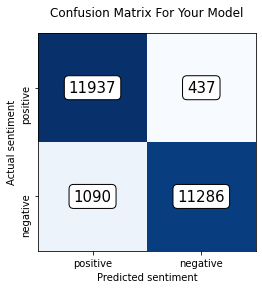

In [25]:
drawConfusionMatrix()

## Reflection

Try running your classification code on your own made-up reviews! Can you make up a review that the model fails on? (The review is positive but it returns negative, vice versa). 

You can also try running the method on single words to see what words are considered indicative of positive or negative sentiment.

Can you think of any bigger datasets that this model would fail on?



## Additional Activity: Improving Your Model By Improving Preprocessing

Look back at the `tokenizing` step of this lab (Part 2). 

Your `tokenize` method includes **preprocessing** steps like lowercasing the text, getting rid of extraneous symbols, and splitting the review into words. This is all to reduce the raw review text into useful information -- important words.


There are really numerous ways to do preprocessing. See if you can improve your `tokenize` method further by employing different methods. 

- One idea is to try removing words that aren't important for analyzing sentiment. 
  - For example, `"I"` and `"or"` aren't really positive or negative (or they shouldn't be!), so they shouldn't have much effect on the final computed sentiment of a review.

- **Hint**: The `nltk` python package is specialized for text analysis and it may have some useful methods for this task.

